## **External Real-Speech Evaluation: LibriSpeech (test-clean)**

After evaluating the model on ASVspoof2019-LA, we perform a second validation step
using the **LibriSpeech test-clean** corpus to assess how well the model generalizes to real human speech recorded outside the ASVspoof benchmark domain.

This evaluation answers an important robustness question:

> **Does the model incorrectly classify genuine human speech as spoofed?**

This is critical because a spoof detector deployed in real-world authentication
systems must minimize **false positive errors** (i.e., rejecting legitimate users), not just detect known spoofing attacks during benchmarking.

We chose LibriSpeech test-clean for the following reasons:

- it contains **only genuine human speech** across multiple speakers,
- audio is recorded under **clean, consistent conditions**, isolating model errors
  from dataset noise,
- all samples are **English** and sampled at **16 kHz**, directly matching our LFCC pipeline,
- transcripts and speaker IDs enable structured error analysis.

Since the entire corpus consists of bona fide speech, any spoof prediction here is
a **false positive**, providing a direct measure of the model's real-world usability
beyond in-distribution ASVspoof test conditions.


## **Imports and Setup**

In [1]:
import os
import numpy as np
import torch
import torchaudio
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Load Saved ASVspoof Project Artifacts**

From the training notebook we saved:

- `lfcc_cnn_model.pth`  → trained model weights
- precomputed LFCC features for train/dev/eval (not needed for Mozilla test)
- zero-shot scores (optional)
- predicted spoof fraction (optional)

We now reconstruct the LFCC CNN architecture and load weights.


## **Load Model**

In [2]:
load_dir = "/content/drive/MyDrive/ASVspoof_LFCC_Project"
model_path = f"{load_dir}/lfcc_cnn_model.pth"

print("Loading model weights from:", model_path)


Loading model weights from: /content/drive/MyDrive/ASVspoof_LFCC_Project/lfcc_cnn_model.pth


## **Reconstruct LFCC-CNN Architecture**

We reconstruct the same LFCC-based CNN used during ASVspoof training.




In [4]:
import torch
import torch.nn as nn

# --- LFCC-CNN baseline model ---

class LFCC_CNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Input flatten dims: 128 * (60//4) * (401//4)
        self.fc = nn.Sequential(
            nn.Linear(128 * (60//4) * (401//4), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.flatten(1)
        return self.fc(x)

# Load weights
load_dir = "/content/drive/MyDrive/ASVspoof_LFCC_Project"
model_path = f"{load_dir}/lfcc_cnn_model.pth"

model = LFCC_CNN().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("Model loaded and ready for inference.")


Model loaded and ready for inference.


## **Load LibriSpeech (External Real Speech)**

Reasons for choosing LibriSpeech:

- English speech only
- Genuine human recordings (no spoofed audio)
- 16 kHz sampling rate (matches LFCC pipeline)
- Multiple speakers and genders
- Clean and consistent studio-quality recordings


In [26]:
import os
os.makedirs("/content/data", exist_ok=True)


In [27]:
import torchaudio

librispeech = torchaudio.datasets.LIBRISPEECH(
    root="/content/data",
    url="test-clean",
    download=True
)

print("Total samples:", len(librispeech))


100%|██████████| 331M/331M [00:19<00:00, 18.2MB/s]


Total samples: 2620


## **Inspect a few sample**

This dataset contains 2620 samples.
Since the model is trained for spoof detection, all samples should ideally be predicted as **bonafide (real)**. Any spoof predictions here represent **false positives** due to domain shift.


In [28]:
import random
import IPython.display as ipd

indices = random.sample(range(len(librispeech)), 3)

for idx in indices:
    waveform, sr, transcript, speaker_id, chapter_id, utterance_id = librispeech[idx]

    print(f"Sample {idx} | Speaker={speaker_id} | Transcript: {transcript}")
    display(ipd.Audio(waveform.squeeze().numpy(), rate=sr))


Sample 2590 | Speaker=908 | Transcript: AND LAY ME DOWN IN THY COLD BED AND LEAVE MY SHINING LOT


Sample 2186 | Speaker=7176 | Transcript: THEN THE LEADER PARTED FROM THE LINE


Sample 2059 | Speaker=7021 | Transcript: THE PAIN PRODUCED BY AN ACT OF HASTY AND ANGRY VIOLENCE TO WHICH A FATHER SUBJECTS HIS SON MAY SOON PASS AWAY BUT THE MEMORY OF IT DOES NOT PASS AWAY WITH THE PAIN


## LFCC Extraction

We extract 60 LFCC coefficients for a fixed 4-second duration to match the
training configuration used in ASVspoof2019-LA.

Output tensor shape:
`(1, 1, 60, 401)`


In [29]:
SAMPLE_RATE = 16000
DURATION = 4.0
MAX_LEN = int(SAMPLE_RATE * DURATION)

lfcc_transform = torchaudio.transforms.LFCC(
    sample_rate=SAMPLE_RATE,
    n_lfcc=60,
    speckwargs={"n_fft":512, "hop_length":160, "win_length":400}
)

def to_lfcc_libri(waveform):
    # waveform shape: (1, T)
    y = waveform.squeeze().numpy()

    # pad or truncate
    if len(y) < MAX_LEN:
        y = np.pad(y, (0, MAX_LEN - len(y)))
    else:
        y = y[:MAX_LEN]

    # wav shape (1,T)
    # lfcc_transform shape (1,60,401)
    # lfcc unsqueeze shape (1,1,60,401)

    wav = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
    lfcc = lfcc_transform(wav)
    lfcc = lfcc.unsqueeze(1).to(device)
    return lfcc


## Inference on 500 LibriSpeech Samples

We randomly sample 500 clips from LibriSpeech test-clean and compute the model's spoof posterior for each clip.

Since all samples are bona fide human speech, any spoof prediction is counted as
a **false positive**.


In [30]:
# Sampling
import random

n = 500
indices = random.sample(range(len(librispeech)), n)

## **Model Inference on Real Speech**

We run the `LFCC-CNN model` on **500** LibriSpeech samples and collect the spoof probability for each clip. All samples are bona fide speech, so the model should ideally assign low spoof scores. Higher scores indicate false positives caused by distribution shift between ASVspoof and LibriSpeech.


In [31]:
from torch.nn.functional import sigmoid

# run inference on 500 librispeech samples

spoof_scores = []        # stores model spoof probabilities
pred_labels = []         # stores predicted labels (1=spoof, 0=real)
speaker_ids = []         # stores speaker id for later analysis

# set model to evaluation mode (no training updates)

model.eval()
with torch.no_grad():    # disable gradient tracking for faster inference
    for idx in indices:
        # load librispeech sample
        waveform, sr, transcript, speaker_id, chapter_id, utterance_id = librispeech[idx]

        # convert waveform to lfcc features
        lfcc = to_lfcc_libri(waveform)

        # forward pass through the model
        logits = model(lfcc).squeeze()

        # convert logits to probability using sigmoid
        score = torch.sigmoid(logits).item()

        # store results
        spoof_scores.append(score)
        pred_labels.append(1 if score > 0.5 else 0)   # threshold at 0.5
        speaker_ids.append(int(speaker_id))


## **Analyze Spoof Scores - False Positive Rate**

In [33]:
# False positive rate

spoof_scores = np.array(spoof_scores)

false_positives = np.sum(spoof_scores > 0.5)
fpr = false_positives / n * 100

print(f"False positives: {false_positives}/{n}")
print(f"False Positive Rate (FPR): {fpr:.2f}%")


False positives: 298/500
False Positive Rate (FPR): 59.60%


**Note:**
Despite achieving competitive performance on ASVspoof2019, the model incorrectly classified `59.6%` of genuine LibriSpeech samples as spoof, indicating severe generalization failure under benign distribution shift.

## **Histogram of Spoof Probabilities**

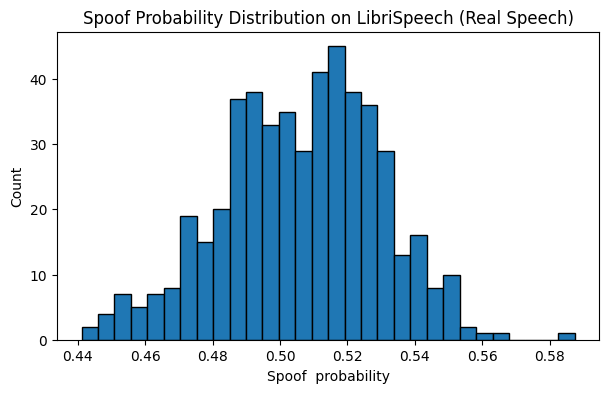

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(spoof_scores, bins=30, edgecolor='black')
plt.xlabel("Spoof  probability")
plt.ylabel("Count")
plt.title("Spoof Probability Distribution on LibriSpeech (Real Speech)")
plt.show()


**Findings from spoof score distribution**

the spoof scores for librispeech cluster tightly around 0.50–0.55, indicating that the model is not confident that real speech is bona fide. because the decision threshold is 0.5, most librispeech samples end up being flagged as spoof, which
produces a high false positive rate on real speech.


### **Speaker-level pattern analysis**

Different speakers may trigger different spoof scores. checking speaker-level patterns helps reveal if the model is biased toward certain voices.


In [37]:
import pandas as pd

df = pd.DataFrame({
    "speaker": speaker_ids,
    "score": spoof_scores
})

speaker_fpr = df.assign(pred=(df.score > 0.5).astype(int)) \
                .groupby("speaker")["pred"].mean() \
                .sort_values(ascending=False)

speaker_fpr.head(10)


,pred
speaker,
1221,1.000000
7729,0.888889
2300,0.833333
260,0.823529
1089,0.818182
5639,0.777778
7021,0.777778
7176,0.750000
8224,0.750000


**Speaker-level analysis findings:**

Some speakers trigger much higher spoof scores than others. for example, several speakers show false positive rates above 0.80 (e.g., speaker 1221: 1.00, 7729: 0.89, 2300: 0.83), even though all clips are real speech. this indicates that false positives are not random but depend on who is speaking.


### **Comparison with Original ASVspoof Performance**

On the ASVspoof2019-LA benchmark, the model performed extremely well on the in-distribution train and development splits:

- AUC: 0.999965  
- EER: 0.2344%  
- Accuracy: 99.8309%  

These results indicate near-perfect separation between bona fide and spoofed samples within the ASVspoof domain.

When evaluating the benchmark's unlabeled development and evaluation splits using predicted spoof fractions, the model estimated:

- Development predicted spoof: 89.91%  
- Evaluation predicted spoof: 71.96%  

These values are expected because both splits contain a mixture of bona fide and synthetic
voice samples, and the spoofing attacks follow controlled and consistent artifact patterns.

In contrast, when the same model was tested on the LibriSpeech test-clean dataset, which contains only real human speech from multiple speakers and recording conditions, the model incorrectly classified 59.6% of the samples as spoof. This reflects a substantial increase in false positives under normal speech variability and domain shift.


### **Why the Model Failed to Generalize?**

Both ASVspoof-LA and LibriSpeech contain real human speech, but they come from different domains. The model learned ASVspoof-specific bona fide patterns and did not generalize to other real speech domains. Key factors:

- **domain mismatch:** ASVspoof speech is controlled; LibriSpeech is audiobook-style.
- **speaker variability:** fewer speakers in ASVspoof vs. many diverse speakers in LibriSpeech.
- **recording channel differences:** more consistent microphones/environments in ASVspoof.
- **prosody/phonetics differences:** conversational vs. expressive reading style.
- **artifact overfitting:** model relied on spoof artifacts instead of modeling bona fide speech.
- **limited bona fide diversity:** only one bona fide domain seen during training.
- **threshold/calibration shift:** scores calibrated to ASVspoof do not transfer to LibriSpeech.

These factors caused unfamiliar bona fide speech to be misclassified as spoof.


### **Practical Implications**

These results show that benchmark-level anti-spoofing performance does not guarantee that a system will accept legitimate users in real conditions. A deployment based on
this model would reject many real speakers, making it unreliable for voice authentication, fraud prevention, or forensic verification.


### **Future Work**

There are a few realistic next steps that build directly on this project:

- **Evaluate on ASVspoof Eval with Ground Truth:**  
  A natural next step is to obtain the ASVspoof evaluation labels to measure how well the model handles unseen attacks within the ASVspoof domain. This was not done here because
  the eval split is unlabeled by default.

- **Test on More Real Speech Datasets:**  
  Evaluating the model on other real speech datasets (e.g., Common Voice, VoxCeleb) would help determine whether the failure on LibriSpeech is dataset-specific or a broader
  generalization issue.

- **Increase Bona Fide Diversity:**  
  Training with more diverse real speech could help the model learn a more general notion of bona fide speech and reduce false positives.

- **Adjust Threshold Calibration:**  
  Tuning the decision threshold or calibrating scores could reduce unnecessary false positives in practical settings.

These steps focus on improving evaluation and understanding without changing the model
architecture.


### **Conclusion**

The model solved the ASVspoof benchmark task but failed to generalize to out-of-domain real speech, highlighting a gap between benchmark success and real-world usability.
